# Predicting Customer Churn with getML on H&M Fashion Dataset

#### *Basic concepts of getML & FastProp*

This notebook showcases how to use [getML](https://getml.com) to predict customer churn with the [H&M Personalized Fashion Recommendations dataset](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data). 

The goal is to demonstrate how even a simple, untuned getML model can outperform competing approaches on real-world, multi-table datasets with minimal effort.

<br>

**Why use getML FastProp?:**
- **Relational Learning.** FastProp (short for Fast Propositionalization) extracts features from related tables without manual SQL or deep business domain expertise.  
- **Blazing Fast.** FastProp runs [60 to 1000 times faster](https://github.com/getml/getml-community?tab=readme-ov-file#benchmarks) than alternatives like [featuretools](https://www.featuretools.com) or [tsfresh](https://tsfresh.com), scaling easily to millions of rows.
- **Superior Performance.** FastProp frequently outperforms graph neural networks and models with handcrafted features on relational learning tasks.  

<br>

**The hm-churn dataset consists of:**
- **3 Tables** (Customers, Articles, Transactions)
- **37 Columns** in total
- **~33 million rows**

This dataset is part of the [Relational Deep Learning Benchmark (RelBench)](http://relbench.stanford.edu/),
maintained at Stanford, which standardizes relational learning tasks.

<br>

**In this notebook, we will:**

1. [Install Dependencies (Optional)](#Step-1:-Installing-Dependencies-(Optional))  
2. [Start the getML Engine and Load the "H&M user-churn" Data](#Step-2:-Starting-the-getML-Engine-and-Loading-the-"H&M-user-churn"-Data)  
3. [Load Data, Inspect, and Set Roles (Data Annotation)](#Step-3:-Loading-Data,-Inspecting,-and-Setting-Roles-(Data-Annotation))
4. [Define the getML DataModel](#Step-4:-Defining-the-getML-DataModel)  
5. [Create a getML Container referncing the Data](#Step-5:-Creating-a-getML-Container-referncing-the-Data)
6. [Define the Pipeline and Check the Data](#Step-6:-Defining-the-getML-Pipeline-and-Chechking-the-Data)
7. [Fitting and Scoring the Pipeline](#Step-7:-Fitting-and-Scoring-the-getML-Pipeline)  
8. [Explore Feature Importances](#Step-8:-Feature-Importances)  
9. [Explore Column Importances](#Step-9:-Column-Importances)

---
## Step 1: Installing Dependencies (Optional)

In [1]:
# We assume you already have all necessary dependencies installed.
# Otherwise, uncomment the line above to install them.

# !pip install pyarrow
# !pip install getml
# !pip install relbench

---
## Step 2: Starting the getML Engine and Loading the "H&M user-churn" Data

In this step, we:
- Start the getML engine
- Download the "rel-hm" dataset and "user-churn" task from RelBench

The "rel-hm" dataset represents relational data on customer interactions, 
and the "user-churn" task focuses on predicting customer churn.


In [2]:
import getml
from relbench.datasets import get_dataset
from relbench.tasks import get_task

# Download the dataset and task
dataset = get_dataset("rel-hm", download=True)
task = get_task("rel-hm", "user-churn", download=True)

# Enable textual output to avoid rendering issues in certain JupyterLab environments
getml.utilities.progress.FORCE_TEXTUAL_OUTPUT = True

# Launch getML engine in memory-mapped mode to handle large datasets 
# Requires less memory (RAM) but is slightly slower.
getml.engine.launch(in_memory=False)
# `in_memory=True` keeps the getML data frames in the RAM

# Set the project name in getML for tracking and managing objects
getml.set_project("hm-churn")

Launching ./getML --allow-push-notifications=true --allow-remote-ips=false --home-directory=/home/jupyter/.getML --in-memory=false --install=false --launch-browser=true --log=false --project-directory=/home/jupyter/.getML/projects in /opt/conda/lib/python3.10/site-packages/getml/.getML/getml-community-1.5.0-amd64-linux...
Launched the getML Engine. The log output will be stored in /home/jupyter/.getML/logs/getml_20250105155813.log


Connected to project 'hm-churn'.


---
## Step 3: Loading Data, Inspecting, and Setting Roles (Data Annotation)


The H&M user-churn dataset includes multiple parquet files:
- customer.parquet
- article.parquet
- transactions.parquet
- population (train/test/val splits) with the "churn" target

#### Objectives:
- Load each table from disk
- Inspect columns to understand the schema
- Assign appropriate roles (join_key, time_stamp, numerical, categorical, etc.)

#### Why Roles Matter
[**Roles**](https://getml.com/latest/user_guide/concepts/annotating_data/#annotating-data-roles) allow getML to:
- Link tables via `join_key`
- Interpret timestamps for time-aware modeling
- Encode numerical, categorical, and text features
- Ignore irrelevant columns (`unused_float` or `unused_string`)


In [3]:
# 1. Customer Table
# -----------------------------------
# First, we load and inspect the customer table to see the structure and columns.
# After that, we will assign roles to ensure proper annotation.

customer = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/db/customer.parquet", 
    "customer"
)

# Inspect the structure of the customer table
customer

name,customer_id,FN,Active,age,club_member_status,fashion_news_frequency,postal_code
role,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string
0,0,nan,nan,49,ACTIVE,NONE,52043ee2162cf5aa7ee79974281641c6...
1,1,nan,nan,25,ACTIVE,NONE,2973abc54daa8a5f8ccfe9362140c632...
2,2,nan,nan,24,ACTIVE,NONE,64f17e6a330a85798e4998f62d0930d1...
3,3,nan,nan,54,ACTIVE,NONE,5d36574f52495e81f019b680c843c443...
4,4,1,1,52,ACTIVE,Regularly,25fa5ddee9aac01b35208d01736e5794...
,...,...,...,...,...,...,...
1371975,1371975,nan,nan,24,ACTIVE,NONE,7aa399f7e669990daba2d92c577b5223...
1371976,1371976,nan,nan,21,ACTIVE,NONE,3f47f1279beb72215f4de557d950e0bf...
1371977,1371977,1,1,21,ACTIVE,Regularly,4563fc79215672cd6a863f2b4bf56b8f...


In [4]:
# Role assignment breakdown on `customer`:
# - **customer_id**: Acts as the primary key, linking to other tables → `join_key`
# - **age**: Numerical data representing customer age → `numerical`
# - **FN, Active, club_member_status, fashion_news_frequency, postal_code**

# Note that "Active" is categorical variables despite being encoded as floats. 
# We set the role as `categorical` since the column has no inherent numerical relationship.

customer.set_role("customer_id", getml.data.roles.join_key)

customer.set_role(["age"], getml.data.roles.numerical)

customer.set_role(
    [
        "FN", 
        "Active", 
        "club_member_status", 
        "fashion_news_frequency",
        "postal_code"
    ], 
    getml.data.roles.categorical
)

In [5]:
# 2. Article table
# -----------------------------------

# Load the article table and inspect its structure before role assignment.
article = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/db/article.parquet", 
    "article"
)

article

name,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_code,index_name,index_group_name,section_name,garment_group_name,detail_desc
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,0,108775,253,1010016,9,4,5,1676,1,16,1002,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,A,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder ...
1,1,108775,253,1010016,10,3,9,1676,1,16,1002,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,A,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder ...
2,2,108775,253,1010017,11,1,9,1676,1,16,1002,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,A,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder ...
3,3,110065,306,1010016,9,4,5,1339,1,61,1017,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,B,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",Microfibre T-shirt bra with unde...
4,4,110065,306,1010016,10,3,9,1339,1,61,1017,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,B,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear",Microfibre T-shirt bra with unde...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105537,105537,953450,302,1010014,9,4,5,7188,3,26,1021,5pk regular Placement1,Socks,Socks & Tights,Placement print,Black,Dark,Black,Socks Bin,F,Menswear,Menswear,Men Underwear,Socks and Tights,Socks in a fine-knit cotton blen...
105538,105538,953763,253,1010016,9,4,5,1919,1,2,1005,SPORT Malaga tank,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey,A,Ladieswear,Ladieswear,H&M+,Jersey Fancy,Loose-fitting sports vest top in...
105539,105539,956217,265,1010016,9,4,5,1641,1,18,1005,Cartwheel dress,Dress,Garment Full body,Solid,Black,Dark,Black,Jersey,A,Ladieswear,Ladieswear,Womens Trend,Jersey Fancy,"Short, A-line dress in jersey wi..."


In [6]:
# Role assignment breakdown on `article`:
# "article_id" acts as the primary key for joining with the transaction table.
# Numerical-encoded categories (e.g., "product_type_no") are set as categorical 

article.set_role("article_id", getml.data.roles.join_key)

article.set_role(
    [
        "product_group_name",
        "department_name",
        "garment_group_name",
        "product_code",
        "product_type_no",
        "graphical_appearance_no",
        "colour_group_code",
        "perceived_colour_value_id",
        "perceived_colour_master_id",
        "department_no",
        "index_group_no",
        "section_no",
        "garment_group_no"
    ],
    getml.data.roles.categorical
)

In [7]:
# 3. Transaction table
# -----------------------------------

# Load the transaction table and inspect its structure before role assignment.
transaction = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/db/transactions.parquet", 
    "transaction"
)

transaction

name,customer_id,article_id,price,sales_channel_id,t_dat
role,unused_float,unused_float,unused_float,unused_float,unused_string
0,155,51985,0.01015,1,2019-09-07 00:00:00.000000000
1,155,51985,0.01015,1,2019-09-07 00:00:00.000000000
2,155,83127,0.04236,1,2019-09-07 00:00:00.000000000
3,155,6066,0.005068,1,2019-09-07 00:00:00.000000000
4,155,78525,0.03388,1,2019-09-07 00:00:00.000000000
,...,...,...,...,...
15453646,1371691,104961,0.05931,2,2020-09-22 00:00:00.000000000
15453647,1371691,100629,0.04236,2,2020-09-22 00:00:00.000000000
15453648,1371721,104053,0.0432,1,2020-09-22 00:00:00.000000000


In [8]:
# Role assignment breakdown on `transactions`:
# - "customer_id" and "article_id" are join keys linking to the customer and article tables.
# - "t_dat" serves as the time stamp, preventing data leakage by ensuring correct temporal boundaries.
# - "price" is numerical, while "sales_channel_id" is categorical.

transaction_roles = getml.data.Roles(
    join_key=["article_id", "customer_id"],
    time_stamp=["t_dat"],
    numerical=["price"],
    categorical=["sales_channel_id"],
)

# Reload the transaction table with roles directly assigned for efficiency.
transaction = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/db/transactions.parquet", 
    "transaction", 
    transaction_roles
)

In [9]:
# 4. Population tables (train, test, val)
# -----------------------------------

# Load and inspect the population (train) table to view its structure before role assignment.
train_tmp = getml.data.DataFrame.from_parquet(
    f"{dataset.cache_dir}/tasks/user-churn/train.parquet", 
    "train_tmp"
)

# Let's inspect the table before we assign the respective roles
train_tmp

name,customer_id,churn,timestamp
role,unused_float,unused_float,unused_string
0,1255921,0,2020-06-08 00:00:00.000000000
1,1256165,0,2020-06-08 00:00:00.000000000
2,1256239,1,2020-06-08 00:00:00.000000000
3,1256569,1,2020-06-08 00:00:00.000000000
4,1256721,1,2020-06-08 00:00:00.000000000
,...,...,...
3832687,1100160,1,2019-12-09 00:00:00.000000000
3832688,1100373,1,2019-12-09 00:00:00.000000000
3832689,1100716,1,2019-12-09 00:00:00.000000000


In [10]:
# Assign roles to the population tables (train, test, val).
# - "customer_id" is the join key.
# - "churn" is the target variable.
# - "timestamp" represents the prediction or cut-off date to prevent data leakage.

population_roles = getml.data.Roles(
    join_key=["customer_id"],
    target=["churn"],
    time_stamp=["timestamp"]
)

train = getml.data.DataFrame.from_parquet(f"{dataset.cache_dir}/tasks/user-churn/train.parquet", "train", population_roles)
val = getml.data.DataFrame.from_parquet(f"{dataset.cache_dir}/tasks/user-churn/val.parquet", "val", population_roles)
test = getml.data.DataFrame.from_parquet(f"{dataset.cache_dir}/tasks/user-churn/test.parquet", "test", population_roles)

---
## Step 4: Defining the getML DataModel

In getML, the [**DataModel**](https://getml.com/latest/user_guide/concepts/data_model/) serves as the foundation for relational feature learning. The DataModel acts as the search space for features, similar to the schema of a relational database. It defines the universe of possible feature paths that getML’s algorithms can explore and learn from.

The data model is structured as a Directed Acyclic Graph, where each [**join**](https://getml.com/latest/user_guide/concepts/data_model/#joins) path represents a potential feature learning route. This structure enables automatic extraction of predictive signals (features) from complex, multi-table datasets.

Trivial joins ([one-to-one](https://getml.com/latest/reference/data/relationship/#getml.data.relationship.one_to_one) or [many-to-one](https://getml.com/latest/reference/data/relationship/#getml.data.relationship.many_to_one)) onto the population don’t produce new features but extend the main table. These paths are useful for enriching data but aren’t part of the feature learning process.

#### For This Churn Use Case:
* The primary feature learning path is the [**one-to-many** relationship](https://getml.com/latest/reference/data/relationship/#getml.data.relationship) between the `population` table and the `transactions` table. This is where most valuable features are derived.
* The `customer` and `article` tables enrich the `population` and `transactions` tables, through tirival joins. However, only the article table introduces new feature learning paths, that the feature learner can aggregate over.

#### Key Concepts: 
* The [**DataModel**](https://getml.com/latest/user_guide/concepts/data_model/) is abstract. It defines the relational structure but does not contain any data itself.
* [**Placeholders**](https://getml.com/latest/user_guide/concepts/data_model/#placeholders) represent tables in the model. These placeholders mirror the schema of actual DataFrames but are decoupled from raw data until the point of training.

In [11]:
# 1) Derive the population placeholder from the “train” DataFrame in our populations dict.
#    These rows form our target population for learning and prediction.

dm = getml.data.DataModel(population=train.to_placeholder())

# 2) Add placeholders for customer, transaction, and article tables.
#    These tables hold valuable information relevant to predictions.
#    Without this step, the predictor cannot access the knowledge within
#    these tables, leading to poorer model performance.

dm.add(getml.data.to_placeholder(customer, transaction, article))

# 3) Specify relational links:
# - population -> customer on "customer_id" (many-to-one)
# - population -> transaction on "customer_id" with time_stamps to prevent data leakage
# - transaction -> article on "article_id" (many-to-one)

dm.population.join(
    dm.customer, 
    on="customer_id", 
    relationship=getml.data.relationship.many_to_one
)

dm.population.join(
    dm.transaction, 
    on="customer_id", 
    time_stamps=("timestamp", "t_dat")
)

dm.transaction.join(
    dm.article, 
    on="article_id", 
    relationship=getml.data.relationship.many_to_one
)

# Visualizing the DataModel (by displaying 'dm' in the notebook)
dm

,data frames,staging table
0,"train, customer",TRAIN__STAGING_TABLE_1
1,"transaction, article",TRANSACTION__STAGING_TABLE_2


---
## Step 5: Creating a getML Container referncing the Data

The [**Container**](https://getml.com/latest/reference/data/container/#getml.data.Container) holds the actual data (train, test, val splits) that will be linked
to the abstract [**DataModel**](https://getml.com/latest/reference/data/data_model/) during pipeline fitting.

Why a Container is an important construct:
- The DataModel defines the relational structure; the Container assigns the data.
- During `pipeline.fit(container.train)`, the Container maps [**data**](https://getml.com/latest/reference/data/data_frame/) to [**placeholders**](https://getml.com/latest/reference/data/placeholder/),
  allowing getML to apply relational joins and time constraints for feature learning.
- No data is duplicated – the Container references the original tables, ensuring efficiency.

This separation enhances reproducibility and keeps data handling modular.

In [12]:
container = getml.data.Container(train=train, val=val, test=test)

# Add peripheral tables (customer, transaction, article) to extend the population.
container.add(customer, transaction, article)

# Display the container to verify all splits and tables are correctly loaded.
container

population
    subset   name       rows   type     
0   train    train   3832692   DataFrame
1   test     test      74575   DataFrame
2   val      val       76556   DataFrame

peripheral
    name              rows   type     
0   customer       1371980   DataFrame
1   transaction   15453651   DataFrame
2   article         105542   DataFrame

---
## Step 6: Defining the getML Pipeline and Chechking the Data

Our [pipeline](https://getml.com/latest/reference/pipeline/) will:
  - Use the DataModel (dm) to understand table relationships,
  - Use [FastProp](https://getml.com/latest/reference/feature_learning/fastprop/) for automated feature engineering,
  - Use [XGBoostClassifier](https://getml.com/latest/reference/predictors/xgboost_classifier/) for prediction.

### Why FastProp is Critical 🚀

**[FastProp](https://getml.com/latest/reference/feature_learning/fastprop/)** (short for Fast Propositionalization) is getML’s open source algorithm for feature learning.
It performs **propositionalization** – transforming relational and time-series data
into a flat table of predictive features through a series of pre-defined aggregations, enabling machine learning models to leverage predictive signals from complex, relational or time-series data.

#### Key Advantages of FastProp:
 - **Speed** – FastProp is up to [**60 to 1000 times faster**](https://github.com/getml/getml-community?tab=readme-ov-file#benchmarks) than competing tools like 
   [featuretools](https://www.featuretools.com) and [tsfresh](https://tsfresh.com).  
 - **Efficiency** – Faster feature generation allows for more iterations, boosting productivity.  
 - **Accuracy** – Despite faster runtimes, FastProp displays **superior predictive performance**, as shown in benchmark results across various datasets.


In [13]:
pipe = getml.Pipeline(
    tags=["base_pipeline"],
    data_model=dm,
    feature_learners=[getml.feature_learning.FastProp(num_threads=8)],
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    predictors=[getml.predictors.XGBoostClassifier(n_jobs=8)],
)

# .check(...) does a static analysis on the pipeline, data model and container 
# to see if everything is consistent (time relationships, roles, table joins, etc.).
# We pass the 'train' subset for verification

pipe.check(container.train)


Checking data model...

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:22--:--
  Checking... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:055m 50% • 00:03


The pipeline check generated 2 issues labeled INFO and 0 issues labeled WARNING.

,type,label,message
0,INFO,MIGHT TAKE LONG,The number of unique entries in column 't3__postal_code' in TRAIN__STAGING_TABLE_1 is 319891. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').
1,INFO,MIGHT TAKE LONG,The number of unique entries in column 't4__product_code' in TRANSACTION__STAGING_TABLE_2 is 33580. This might take a long time to fit. You should consider setting its role to unused_string or using it for comparison only (you can do the latter by setting a unit that contains 'comparison only').


In [14]:
# Based on the info- and warning-messages, we might decide to mark certain columns unused.
# In this example, we realize that 'product_code' or 'postal_code' are not helpful:
article.set_role("product_code", getml.data.roles.unused_string)
customer.set_role("postal_code", getml.data.roles.unused_string)

# Because roles have changed, we can recreate another container 
# so the pipeline sees the updated roles and avoid any warnings.
container_checked = getml.data.Container(train=train, val=val, test=test)
container_checked.add(customer, transaction, article)

container_checked

population
    subset   name       rows   type     
0   train    train   3832692   DataFrame
1   test     test      74575   DataFrame
2   val      val       76556   DataFrame

peripheral
    name              rows   type     
0   customer       1371980   DataFrame
1   transaction   15453651   DataFrame
2   article         105542   DataFrame

---
## Step 7: Fitting and Scoring the getML Pipeline

In [15]:
# .fit(...) orchestrates learning the features, and training the prediction model. 

pipe.fit(container_checked.train, check=False)

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:22--:--
  FastProp: Trying 64 features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:22
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:256% • 00:01
  XGBoost: Training as predictor... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 02:52m • 00:0200:04


Trained pipeline.

Time taken: 0:03:40.767034.



Pipeline(data_model='train',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=False,
         loss_function='CrossEntropyLoss',
         peripheral=['article', 'customer', 'transaction'],
         predictors=['XGBoostClassifier'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['base_pipeline', 'container-Q0diwV'])

In [16]:
# We now evaluate the pipeline on the validation and test sets:

pipe.score(container_checked.val)
pipe.score(container_checked.test)
pipe.scores

# Observing the results in pipe.scores, we find the current pipeline 
# meets our performance needs. Therefore, we will skip further optimizations 
# of the data model, feature learner, or pipeline hyperparameters at this stage.

# As a final step, we will explore feature importances, column importances, 
# and examine the logical structure of our learned features. This helps us 
# understand how the pipeline is deriving its predictions and whether 
# certain aspects of the data are particularly influential.

  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:14--:--
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:14
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:02 • --:--
  Staging... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:13--:--
  Preprocessing... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:0000:13
  FastProp: Building features... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% • 00:02 • --:--


,date time,set used,target,accuracy,auc,cross entropy
0,2025-01-05 16:03:48,train,churn,0.8243,0.6883,0.4358
1,2025-01-05 16:04:06,val,churn,0.8218,0.7117,0.434
2,2025-01-05 16:04:22,test,churn,0.833,0.7066,0.4209


---
## Step 8: Feature Importances

Since we used XGBoost, we can query each engineered feature's importance. 
This helps us to understand which features matter for churn.

Total number of features: 64


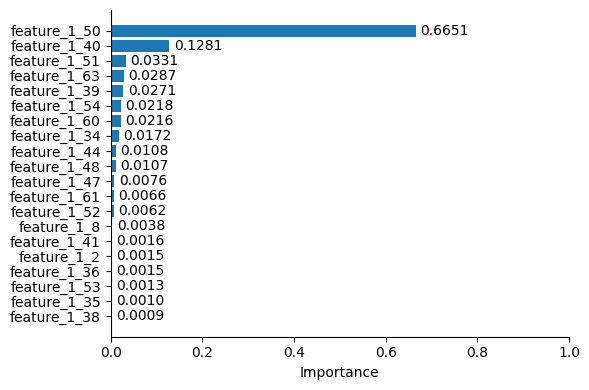

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_importances(names, importances, top_n=None):
    """
    Creates a bar chart of importances. 
    Ensures a horizontal layout so we can see longer names easily.
    """
    import pandas as pd
    df = pd.DataFrame({"name": names, "importance": importances}) \
             .sort_values("importance", ascending=False)
    if top_n:
        df = df.head(top_n)
    df = df.iloc[::-1].reset_index(drop=True)
    
    plt.figure(figsize=(6,4))
    plt.barh(df["name"], df["importance"], color="C0")
    plt.xlabel("Importance")
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.xlim(0,1)
    
    for i, val in enumerate(df["importance"]):
        plt.text(val + 0.01, i, f"{val:.4f}", va="center")
    
    plt.tight_layout()
    plt.show()

# Retrieve feature importances from the pipeline
feat_names, feat_importances = pipe.features.importances()

print(f"Total number of features: {len(feat_names)}")

# Plot top 20
plot_importances(feat_names, feat_importances, top_n=20)

In [18]:
# If you want to see the underlying SQL logic for the top features:

sql_feature_top1 = pipe.features.to_sql()[feat_names[0]]
print(sql_feature_top1)

DROP TABLE IF EXISTS "FEATURE_1_50";

CREATE TABLE "FEATURE_1_50" AS
SELECT COUNT( DISTINCT t2."t_dat" ) AS "feature_1_50",
       t1.rowid AS rownum
FROM "TRAIN__STAGING_TABLE_1" t1
INNER JOIN "TRANSACTION__STAGING_TABLE_2" t2
ON t1."customer_id" = t2."customer_id"
WHERE t2."t_dat" <= t1."timestamp"
GROUP BY t1.rowid;


In [19]:
# *Interpretation of feature 1:* This feature is the count of distinct transaction dates
#  for a given customer prior to the churn-prediction timestamp. 
#  In simpler terms, "How many separate shopping days has the customer had?"

sql_feature_top2 = pipe.features.to_sql()[feat_names[1]]
print(sql_feature_top2)

DROP TABLE IF EXISTS "FEATURE_1_40";

CREATE TABLE "FEATURE_1_40" AS
SELECT MAX( t2."t_dat" ) AS "feature_1_40",
       t1.rowid AS rownum
FROM "TRAIN__STAGING_TABLE_1" t1
INNER JOIN "TRANSACTION__STAGING_TABLE_2" t2
ON t1."customer_id" = t2."customer_id"
WHERE t2."t_dat" <= t1."timestamp"
GROUP BY t1.rowid;


In [20]:
# *Interpretation of feature 2:* 'TREND' is a function that measures how transaction
#  dates cluster over time, indicating momentum or recency in the user's 
#  shopping behavior.

---
## Step 9: Column Importances

Beyond feature importances, getML can also compute "column importances," showing how each original column (like 'age', 'price', or 'department_name') contributed overall to the final model. 
This is particularly useful if you want to prune entire columns that have negligible relevance for churn.

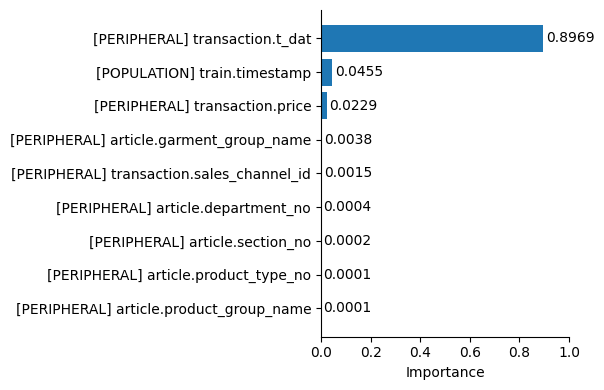

In [21]:
col_names, col_importances = pipe.columns.importances()
plot_importances(col_names, col_importances)

# If, for example 'colour_group_code' or 'department_no' are extremely low, 
# we might decide to remove them. 
# This is valuable when dealing with very large data 
# to speed up the pipeline and reduce noise.


---
## Conclusion  

In this notebook, we demonstrated how to build a **time-aware, relational** model for customer churn prediction using getML. We:  
1. Loaded and annotated the data (population, transactions, articles, and customers),  
2. Defined a DataModel to represent their relationships,  
3. Applied getML's FastProp for automated feature engineering using propositionalization,  
4. Trained an XGBoostRegressor to predict item-level sales,  
5. Evaluated performance on validation and test sets,  
6. Analyzed feature and column importances for interpretability.  

This provides a solid foundation for churn prediction. While further tuning and feature engineering can enhance accuracy, this analysis highlights the strength of getML in terms of model performance, ease of use, and interpretability with minimal code.  

**Next Steps:**  
To explore model tuning or integrate custom predictors with getML's features, check out `hm-item.ipynb` in this repository, which focuses on item sales prediction using regression techniques.